In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# $\star$ Question 1:

Run the Sklearn implementations of k-means and expectation maximization on the dataset *gaussianplus.npz*.


Plot the estimated assignments and the estimated
parameters of the two Gaussians. 

Describe how the fitting by expectation maximization outperforms the one with k-means.

Try with varying, also
very bad initializations. How stable are the results?

In [3]:
# Load Data from gaussianplus
gp = np.load('../data/gaussianplus.npz', mmap_mode='r')['arr_0']
print(gp.shape)

(120, 2)


In [4]:
# K-Means Clustering using Sklearn
clusters = KMeans(n_clusters=2, random_state=0).fit(gp)
labels = clusters.labels_

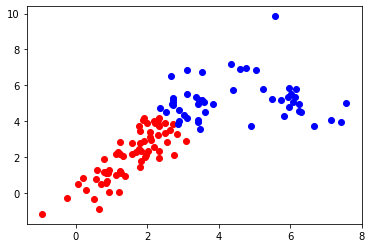

In [71]:
cluster1 = gp[labels == 1]
cluster2 = gp[labels == 0]
plt.scatter(cluster1[:, 0], cluster1[:, 1], color='red')
plt.scatter(cluster2[:, 0], cluster2[:, 1], color='blue')

In [382]:
# Expectation Maximization using Gaussian Mixtures
gm = GaussianMixture(n_components=2, random_state=0).fit(gp)
means = gm.means_
covs = gm.covariances_
weights = gm.weights_
print(means)

[[2.11855468 3.11168998]
 [6.08750679 4.96159276]]


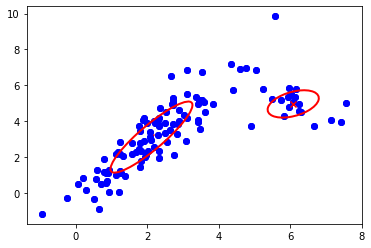

In [73]:
fig, ax = plt.subplots()

for i in range(0, 2):
    eig_w, eig_v = np.linalg.eig(covs[i])
    ell = Ellipse(xy=means[i], width=np.sqrt(eig_w[0])*2, height=np.sqrt(eig_w[1])*2, angle=np.rad2deg(np.arccos(eig_v[0, 0])), edgecolor='red', lw=2, facecolor='none')
    ax.add_artist(ell)
    plt.scatter(gp[:, 0], gp[:, 1], color='blue')
    plt.scatter(means[i, 0], means[i, 1], c="red", marker="x")

# $\star\star\star$  Question 2:

Build your own implementations of k-means and EM to learn in
detail how these important algorithms work.

Compare your implementation with the sklearn
implementation.

In [6]:
# Build K-Means Clustering from scratch
import numpy.random as random
from math import inf
K = 2
idx1, idx2 = random.randint(0, len(gp)), random.randint(0, len(gp))
means = [gp[idx1, :], gp[idx2, :]]

assignment = [-1 for i in range(len(gp))]

In [94]:
def define_cluster(assignment, gp, means):
    for i in range(0, len(gp)): # Assign each data sample to a cluster depending on its distance from the cluster center
        min_dist = inf
        for j in range(0, K):
            if np.linalg.norm(gp[i, :] - means[j]) < min_dist:
                min_dist = np.linalg.norm(gp[i, :] - means[j])
                assignment[i] = j
    return np.array(assignment)

In [95]:
assignment = define_cluster(assignment, gp, means)

In [126]:
def plot_clusters(assignment, gp, means):
    cluster1 = gp[assignment == 0]
    cluster2 = gp[assignment == 1]
    
    plt.scatter(cluster1[:, 0], cluster1[:, 1], color='red')
    plt.scatter(cluster2[:, 0], cluster2[:, 1], color='blue')
    
    plt.scatter(means[0, 0], means[0, 1], marker='^', color='black')
    plt.scatter(means[1, 0], means[1, 1], marker='^', color='black')
    
    plt.show()
    
    return cluster1, cluster2

Initialized Means : [0 8], [4 0]


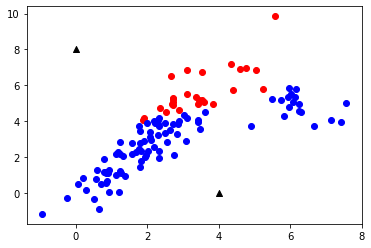

New Means : [3.43470259 5.67338798], [2.59186612 2.76667639]


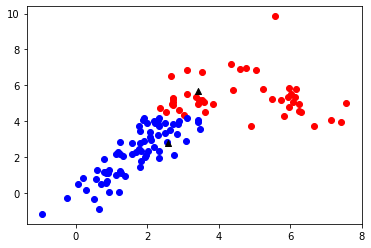

New Means : [4.60959314 5.34650668], [1.68465103 2.26519439]


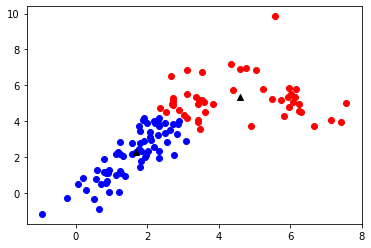

New Means : [4.50765811 5.23111316], [1.59021509 2.17123711]


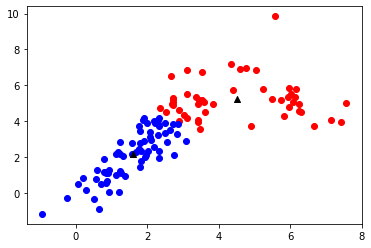

New Means : [4.47527286 5.20701391], [1.57166965 2.14473835]


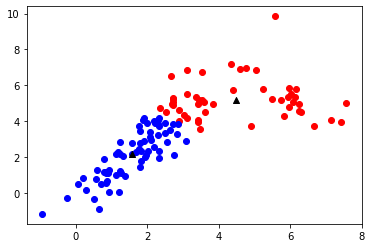

New Means : [4.47527286 5.20701391], [1.57166965 2.14473835]


In [129]:
means = np.array([[0, 8], [4, 0]])
print("Initialized Means : {}, {}".format(means[0, :], means[1, :]))
for i in range(0, 5):
    assignment = define_cluster(assignment, gp, means)
    c1, c2 = plot_clusters(assignment, gp, means)
    means = np.array([np.mean(c1, axis=0), np.mean(c2, axis=0)])
    print("New Means : {}, {}".format(np.mean(c1, axis=0), np.mean(c2, axis=0)))

In [39]:
# Expectation Maximization from scratch
def initialize_parameters():
    means = np.array([[0.0, 4.0], [4.0, 4.0]])
    covs = np.array([np.asmatrix(np.identity(2)) for i in range(K)])
    weights = [1 / K for k in range(0, K)]
    
    return means, covs, weights
means, covs, weights = initialize_parameters()

In [40]:
from numpy import pi, exp
def multivariate_gaussian(x, mean, cov, d):
    x_diff = x - mean
    prod = 1 / ((np.linalg.det(cov) ** 0.5) * (2 * pi) ** (d / 2)) 
    return prod * exp(-0.5 * x_diff.T @ np.linalg.inv(cov) @ x_diff)

print(multivariate_gaussian(gp[0, :], means[0, :], covs[0, :], 2))
print(stats.multivariate_normal.pdf(gp[0, :], means[0, :], covs[0, :]))

0.005513885324716246
0.005513885324716247


In [41]:
from scipy import stats
# Responsibility - Expectation of the Posterior
def E_step(x_n, means, covs, weights):
    resp = np.zeros((x_n.shape[0], K))
    for i in range(len(x_n)):
        for k in range(0, K):
#             val = stats.multivariate_normal.pdf(x_n[i, :], means[k, :], covs[k, :])
            val = multivariate_gaussian(x_n[i, :], means[k, :], covs[k, :], 2)
            resp[i, k] = val * weights[k]
    
    resp = resp / np.sum(resp, axis=1)[:, None]
    return resp
    
# Responsibility is an N*K matrix
resp = E_step(gp, means, covs, weights)
print(resp.shape)

(120, 2)


In [90]:
# Maximization Step
def M_step(x_n, resp, means, covs, weights):
    N_K = resp.sum(axis=0)[:, None]
    
    for k in range(0, K):
        means[k, :] = (1 / N_K[k]) * np.sum(resp[:, k][:, np.newaxis] * x_n, axis=0)
        
        x_diff = x_n - means[k, :]
        covs[k, :] = (1 / N_K[k]) * (x_diff.T * resp[:, k]).dot(x_diff)
        
        weights[k] = N_K[k] / x_n.shape[0]
    
    return means, covs, weights

In [91]:
def plot_EM_cluster(x_n, resp, means):
    labels = np.array([resp[n, 0] > resp[n, 1] for n in range(0, x_n.shape[0])])
    
    cluster1 = x_n[labels == 0]
    cluster2 = x_n[labels == 1]
    
    plt.scatter(cluster1[:, 0], cluster1[:, 1], color='red')
    plt.scatter(cluster2[:, 0], cluster2[:, 1], color='blue')
    
    plt.scatter(means[0, 0], means[0, 1], marker='^', color='black')
    plt.scatter(means[1, 0], means[1, 1], marker='^', color='black')
    
    plt.show()

In [102]:
def expectation_maximization(x_n):
    means, covs, weights = initialize_parameters()
    
    for n in range(0, 20):
        # E Step
        resp = E_step(x_n, means, covs, weights)
        
        plot_EM_cluster(gp, resp, means)
        
        # M Step
        means, covs, weights = M_step(x_n, resp, means, covs, weights)

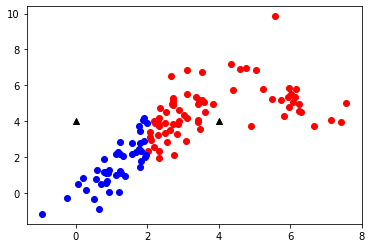

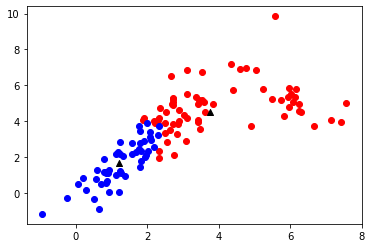

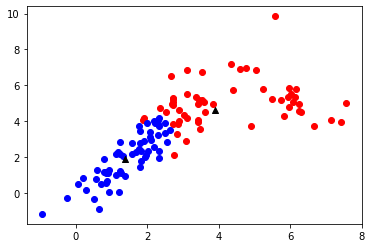

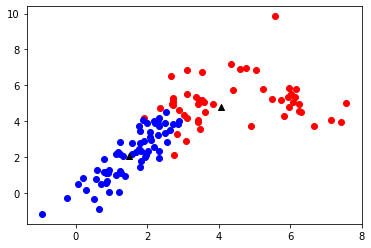

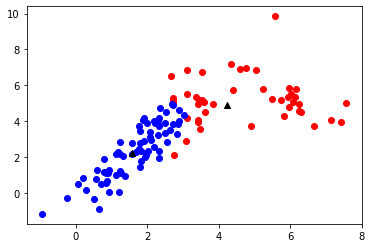

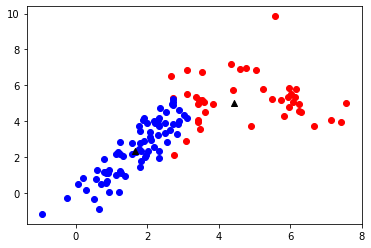

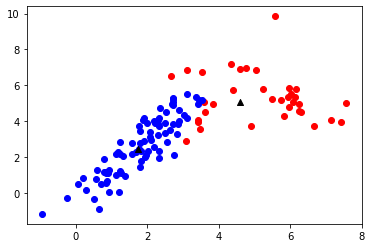

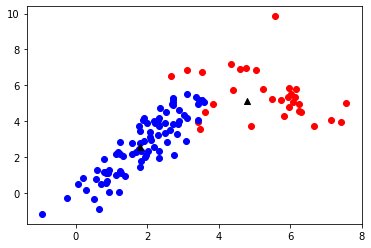

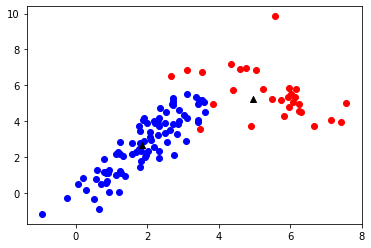

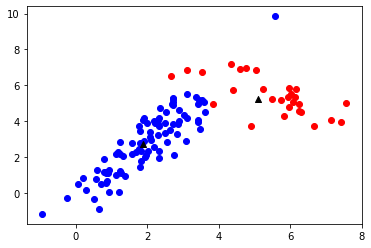

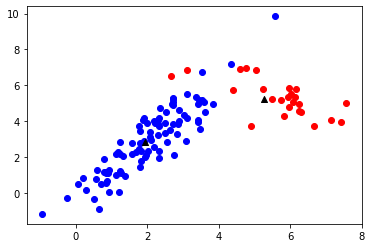

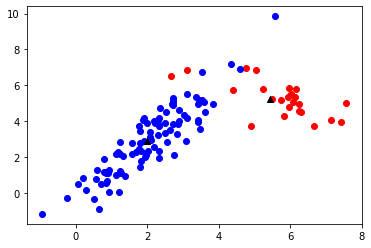

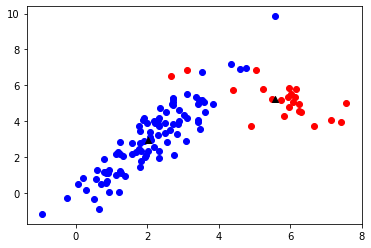

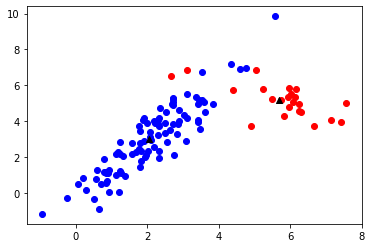

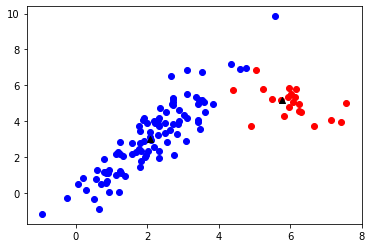

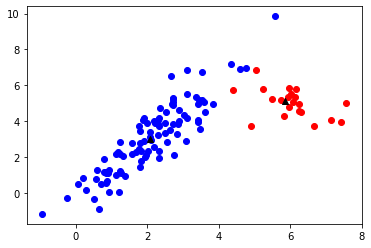

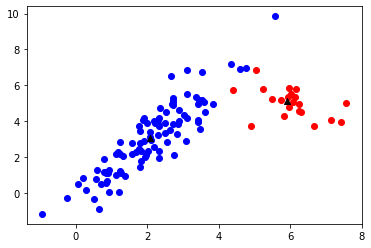

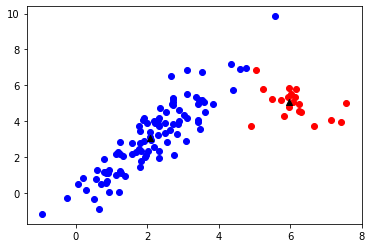

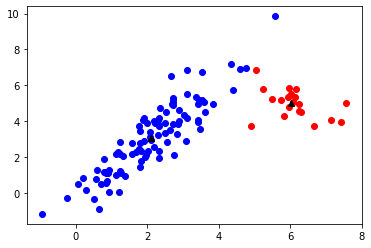

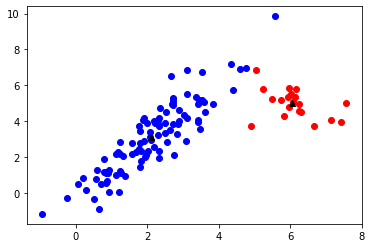

None


In [103]:
print(expectation_maximization(gp))

In [97]:
print(means)
print(covs)

[[0. 4.]
 [4. 4.]]
[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
